# Deep Q-Network and VAE

### Import the Necessary Packages

In [4]:
import gym
from gym import wrappers
from atari_wrappers import wrap_deepmind

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F

import math, random
import matplotlib.pyplot as plt

import agent
import utils

### CUDA

In [6]:
CUDA = torch.cuda.is_available()

### Constants

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
INITIAL_BUF = int(2e3)  # initial replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.9             # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

### Setup Atari Envoronment

In [8]:
env = gym.make('PongNoFrameskip-v4')
env = wrap_deepmind(env)
observation = env.reset() 
print('Observation Space Shape: {}'.format(env.observation_space.shape))
print('Num Actions: {}'.format(env.action_space.n))

Observation Space Shape: (84, 84, 1)
Num Actions: 6


/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'atari_wrappers.ProcessFrame84'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Import DQN

In [11]:
import dqn
model = dqn.DQN(env.observation_space.shape, env.action_space.n)

if CUDA:    
    model = model.cuda()

### Set Optimizer

In [8]:
optimizer = optim.Adam(model.parameters(), lr=LR)

### Set up Replay Buffer for Experience Replay

In [10]:
import agent
replay_buffer = agent.ReplayBuffer(action_size=env.action_space.n, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=0)

### Load Saved Model

In [ ]:
model.load_state_dict(torch.load('./breakout_dqn_model_2'))
model.eval()

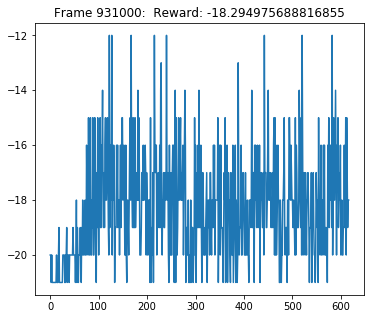

### Load pre-generated noisy and clean frames to test VAE

In [14]:
noisy_frames = torch.load('./noisy_frames')
clean_frames = torch.load('./original_frames')

In [15]:
print(noisy_frames.shape)

(779, 1, 84, 84)


NameError: name 'noisy_frames' is not defined

### Set up Data Loaders

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


In [17]:
dataset = CustomDataset(noisy_frames, clean_frames)
loader = DataLoader(
    dataset,
    batch_size=20,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

### Import VAE and DAE from /defenses/denoise_autoencoder and /defenses/vae

In [18]:
import vae

In [19]:
vae_model = vae.VAE(image_channels=1)

In [18]:
vae_model.load_state_dict(torch.load('./vae_model'))

In [20]:
vae_model = VAE(image_channels=1)
vae_model = vae_model.cuda()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-4)

In [22]:
#train the Denoising AutoEncoder
for i in range(20):
    print('epoch: {}'.format(i))
    total_iter = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(loader):
        noisy = Variable(data)
        noisy = (noisy.type(torch.FloatTensor)/255.0).cuda()
        noisy = noisy_image/255.0
        noisy = noisy_image.cuda()
        clean = Variable(target)
        clean = (clean.type(torch.FloatTensor)/255.0).cuda()
        noise_only = (Variable(target.type(torch.FloatTensor) - data, requires_grad=True).type(torch.FloatTensor)).cuda()
        
        optimizer.zero_grad()
        
        output, mu, logvar = vae_model(noisy_image) 
        loss.backward()
        optimizer.step()
        total_iter += 1
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            print(loss.item())
    print('total loss: {}'.format(total_loss))

epoch: 0
batch_idx: 0 / 39
5008474.5
total loss: 184097621.25
epoch: 1
batch_idx: 0 / 39
5536815.0
total loss: 184097620.5
epoch: 2
batch_idx: 0 / 39
5072968.0
total loss: 184097620.5
epoch: 3
batch_idx: 0 / 39
5124539.5
total loss: 184097621.75
epoch: 4
batch_idx: 0 / 39
3739012.5
total loss: 184097622.5
epoch: 5
batch_idx: 0 / 39
4623434.0
total loss: 184097622.75
epoch: 6
batch_idx: 0 / 39
5640107.0
total loss: 184097623.75
epoch: 7
batch_idx: 0 / 39
4554225.5
total loss: 184097622.5
epoch: 8
batch_idx: 0 / 39
4533495.0
total loss: 184097622.5
epoch: 9
batch_idx: 0 / 39
4850327.0
total loss: 184097620.25
epoch: 10
batch_idx: 0 / 39
4889502.5
total loss: 184097622.75
epoch: 11
batch_idx: 0 / 39
5309925.0
total loss: 184097626.25
epoch: 12
batch_idx: 0 / 39
5608993.5
total loss: 184097623.5
epoch: 13
batch_idx: 0 / 39
5007980.5
total loss: 184097624.25
epoch: 14
batch_idx: 0 / 39
5113811.5
total loss: 184097623.0
epoch: 15
batch_idx: 0 / 39
5628261.0
total loss: 184097622.5
epoch: 16



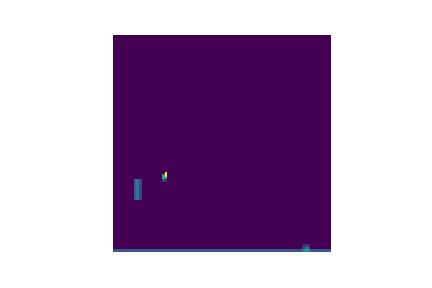


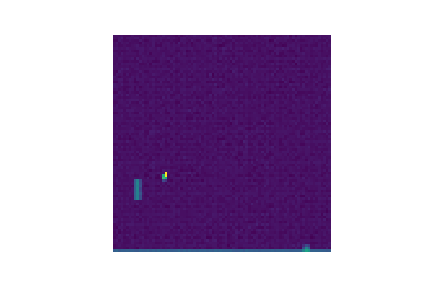


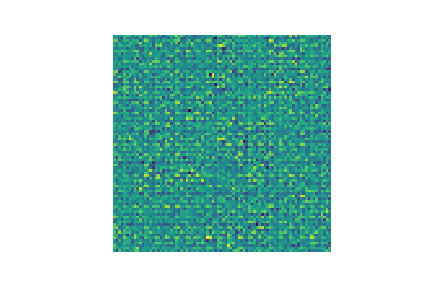

0.19674067


In [26]:
observation = next(iter(loader))[0][1]
observation = observation.type(torch.FloatTensor)
observation = observation / 255.
noise, _, _ = vae_model(observation.reshape(1, 1, 84, 84).cuda())
reconstructed = (observation - noise.detach().cpu()).squeeze().numpy()
observation = observation.detach().cpu().squeeze().numpy()
display_frames([observation])
display_frames([reconstructed])
display_frames([noise.detach().cpu().squeeze().numpy()])